# Subjectivity in News Articles

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it
- Matteo Fasulo - matteo.fasulo@studio.unibo.it
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses Task 1 proposed in [CheckThat Lab](https://checkthat.gitlab.io/clef2025/) of CLEF 2025. In this task, systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.

This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).

The task comprises three settings:

* Monolingual: train and test on data in a given language
* Multilingual: train and test on data comprising several languages
* Zero-shot: train on several languages and test on unseen languages

training data in five languages:
* Arabic
* Bulgarian
* English
* German
* Italian

The official evaluation is macro-averaged F1 between the two classes.

In [3]:
import os
import gc
from pathlib import Path

import csv

import numpy as np
import pandas as pd

from tqdm import tqdm

from joblib import delayed, Parallel

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn

from sentence_transformers import SentenceTransformer
from datasets import Dataset
from huggingface_hub import notebook_login
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, RobertaTokenizerFast, RobertaForSequenceClassification, pipeline

In [4]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [5]:
data_folder = '/kaggle/input/clef2025-checkthat/data' # data
dataset = pd.DataFrame(columns=['sentence_id','sentence','label','lang','split'])

for language in os.listdir(data_folder):
    for filename in os.listdir(f"{data_folder}{os.sep}{language}"):
        if '.tsv' in filename:
            abs_path = f"{data_folder}{os.sep}{language}{os.sep}{filename}"
            df = pd.read_csv(abs_path, sep='\t', quoting=csv.QUOTE_NONE)
            if 'solved_conflict' in df.columns:
                df.drop(columns=['solved_conflict'], inplace=True)
            df['lang'] = language
            df['split'] = Path(filename).stem
            dataset = pd.concat([dataset, df], axis=0)

In [6]:
train = dataset[dataset['split'].str.contains('train')].copy()
dev = dataset[dataset['split'].str.contains('dev')].copy()
test = dataset[dataset['split'].str.contains('dev_test')].copy()

print(f"Train: {train.shape}")
print(f"Dev: {dev.shape}")
print(f"Test: {test.shape}")

Train: (6418, 5)
Dev: (4733, 5)
Test: (2332, 5)


In [7]:
print(f"Train: {train['label'].value_counts(normalize=True)}")
print(f"Dev: {dev['label'].value_counts(normalize=True)}")
print(f"Test: {test['label'].value_counts(normalize=True)}")

Train: label
OBJ     0.631349
SUBJ    0.368651
Name: proportion, dtype: float64
Dev: label
OBJ     0.634481
SUBJ    0.365519
Name: proportion, dtype: float64
Test: label
OBJ     0.657376
SUBJ    0.342624
Name: proportion, dtype: float64


Legend:
* Objective -> 0
* Subjective -> 1

In [8]:
train.loc[:, 'label'] = train['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
dev.loc[:, 'label'] = dev['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
test.loc[:, 'label'] = test['label'].apply(lambda x: 0 if x == 'OBJ' else 1)

In [9]:
train['label'] = train['label'].astype(int)
dev['label'] = dev['label'].astype(int)
test['label'] = test['label'].astype(int)

In [10]:
#notebook_login()

# Baseline Model

In [ ]:
vect = SentenceTransformer("all-mpnet-base-v2")

In [ ]:
model = LogisticRegression(class_weight="balanced", random_state=SEED)
model.fit(X=vect.encode(train['sentence'].values), y=train['label'].values)

In [ ]:
predictions = model.predict(X=vect.encode(test['sentence'].values)).tolist()

In [ ]:
pred_df = pd.DataFrame()
pred_df['sentence_id'] = test['sentence_id']
pred_df['label'] = predictions

In [ ]:
def evaluate_model(gold_values, predicted_values):
    acc = accuracy_score(gold_values, predicted_values)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(gold_values, predicted_values, average="macro",
                                                               zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(gold_values, predicted_values, labels=[1],
                                                               zero_division=0)
    #roc_auc = roc_auc_score(gold_values, predicted_probabilities)

    return {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc,
        #'roc_auc': roc_auc
    }

In [ ]:
evaluate_model(gold_values=test.label.values, predicted_values=predictions)

In [ ]:
torch.cuda.empty_cache()

del model

gc.collect()

# Twitter RoBERTa-base 2022 154M

In [73]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_card, use_Fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_card, num_labels=2, id2label={0: 'OBJ', 1: 'SUBJ'}, label2id={'OBJ': 0, 'SUBJ': 1})

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
def preprocess_text(texts):
    return tokenizer(
      texts['sentence'],
      add_special_tokens = True,
      max_length = 40,
      padding='max_length',
      truncation=True,
      return_tensors = 'pt'
    )

In [75]:
train_dl = Dataset.from_pandas(train)
train_dl = train_dl.map(preprocess_text, batched=True)

dev_dl = Dataset.from_pandas(dev)
dev_dl = dev_dl.map(preprocess_text, batched=True)

Map:   0%|          | 0/6418 [00:00<?, ? examples/s]

Map:   0%|          | 0/4733 [00:00<?, ? examples/s]

In [76]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [77]:
training_args = TrainingArguments(
    output_dir=f'model',                 
    learning_rate=6e-5,
    per_device_train_batch_size=32,         
    per_device_eval_batch_size=32,
    #lr_scheduler_type='linear',
    warmup_steps=600,
    #label_smoothing_factor=0.1,
    num_train_epochs=5,
    weight_decay=1e-1,
    eval_strategy="epoch",       
    save_strategy="epoch",           
    #save_safetensors=True,
    load_best_model_at_end=True,
    report_to='none',
    seed=SEED,
    data_seed=SEED
)

In [78]:
# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, class_weights, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # You pass the class weights when instantiating the Trainer
        self.class_weights = class_weights
        self.device = device

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We extract the logits from the model outputs
            logits = outputs.get('logits')
            # We compute the loss manually passing the class weights to the loss function
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.device)) # Modified to use the class weights
            # We compute the loss using the modified criterion
            loss = criterion(logits, inputs['labels'])

        return (loss, outputs) if return_outputs else loss

In [79]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train['label']), y=train['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float32)
class_weights

tensor([0.7920, 1.3563])

In [80]:
def compute_metrics(output_info):
    """
    Compute various evaluation metrics for model predictions.
    
    Args:
        output_info (tuple): A tuple containing the model predictions and the true labels.
            - predictions (np.ndarray): The predicted labels from the model.
            - labels (np.ndarray): The true labels.
    
    Returns:
        dict: A dictionary containing the computed metrics:
            - 'f1': The F1 score (macro average).
            - 'accuracy': The accuracy score.
            - 'precision': The precision score (macro average).
            - 'recall': The recall score (macro average).
    """
    predictions, labels = output_info
    predictions = np.array(predictions)
    labels = np.array(labels)
    predictions = np.argmax(predictions, axis=-1)
    
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)
    acc = accuracy_score(labels, predictions)
    
    return {"f1-score" : f1, "Accuracy" : acc}

In [81]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dl,
    eval_dataset=dev_dl,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    device=device,
)

In [82]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1-score,Accuracy
1,No log,0.587439,0.664156,0.664272
2,No log,0.545999,0.710043,0.719417
3,0.563100,0.560786,0.674517,0.675259
4,0.563100,0.668029,0.704099,0.735263
5,0.354800,0.973905,0.701694,0.728925


TrainOutput(global_step=1005, training_loss=0.4579478355189461, metrics={'train_runtime': 329.7555, 'train_samples_per_second': 97.315, 'train_steps_per_second': 3.048, 'total_flos': 659639467665600.0, 'train_loss': 0.4579478355189461, 'epoch': 5.0})

Map:   0%|          | 0/748 [00:00<?, ? examples/s]

Prediction of language: arabic
F1 Macro: 0.4230561061209249


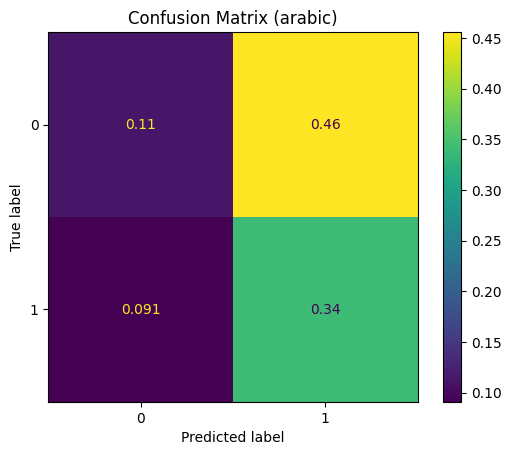

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Prediction of language: bulgarian
F1 Macro: 0.7903615646426281


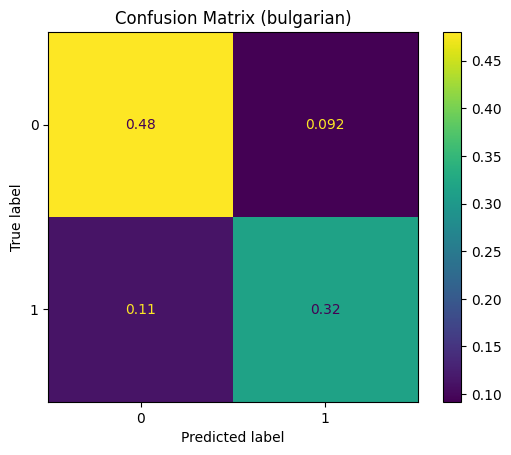

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Prediction of language: english
F1 Macro: 0.7139479905437353


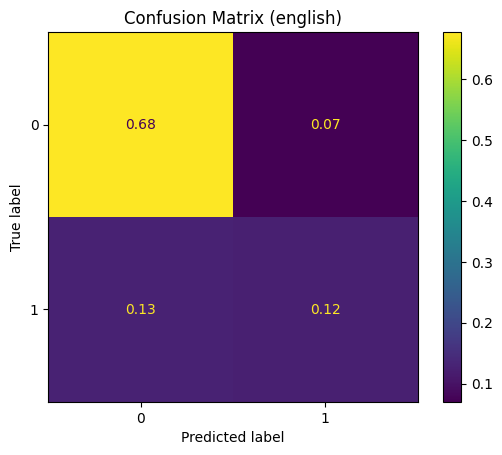

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Prediction of language: german
F1 Macro: 0.8494366744366744


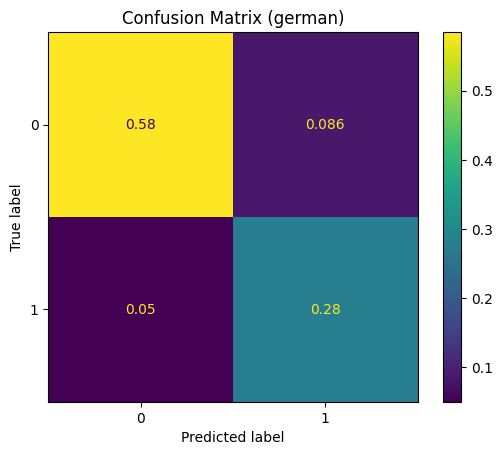

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Prediction of language: italian
F1 Macro: 0.7693166488347212


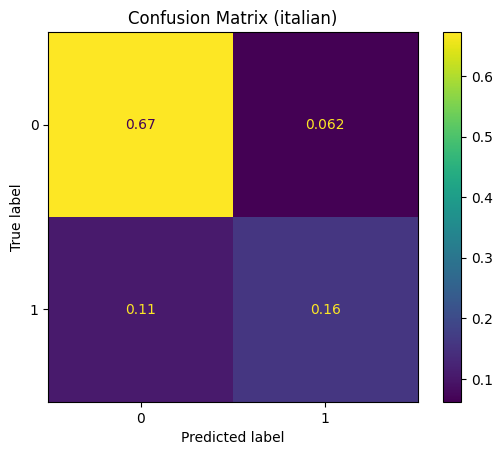

In [92]:
results_df = pd.DataFrame(columns=['model','f1_macro','acc','lang'])

for language in test['lang'].unique():
    test_dl = Dataset.from_pandas(test[test['lang'] == language])
    test_dl = test_dl.map(preprocess_text, batched=True)
    predictions, labels, _ = trainer.predict(test_dl)
    predictions = np.argmax(predictions, axis=1)
    f1_macro = f1_score(labels, predictions, average="macro", zero_division=0)
    acc = accuracy_score(labels, predictions)

    results_df.loc[len(results_df)] = [model_card, f1_macro, acc, language]

    print("Prediction of language:", language)
    print("F1 Macro:", f1_score(labels, predictions, average="macro", zero_division=0))
    
    ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='all')
    plt.title(f"Confusion Matrix ({language})")
    plt.show()

In [93]:
results_df

,model,f1_macro,acc,lang
0,microsoft/mdeberta-v3-base,0.423056,0.453209,arabic
1,microsoft/mdeberta-v3-base,0.790362,0.796000,bulgarian
2,microsoft/mdeberta-v3-base,0.713948,0.801653,english
3,microsoft/mdeberta-v3-base,0.849437,0.863501,german
4,microsoft/mdeberta-v3-base,0.769317,0.830409,italian


# Emotions

In [ ]:
model_card = "arpanghoshal/EmoRoBERTa"
tokenizer = RobertaTokenizerFast.from_pretrained(model_card)
model = RobertaForSequenceClassification.from_pretrained(model_card, from_tf=True)

In [ ]:
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa', return_all_scores= True)

In [ ]:
# Example
print(train_data.iloc[0]['sentence'], train_data.iloc[0]['label'])
emotion_labels = emotion(train_data.iloc[0]['sentence'])
pd.DataFrame(emotion_labels[0]).sort_values(by='score', ascending=False)

In [ ]:
emotion_array = np.zeros((train_data.shape[0], 28))

for i, sentence in enumerate(tqdm(train_data['sentence'])):
    result = emotion(sentence)[0]
    emotion_array[i] = np.array([list(d.values())[1] for d in result])

In [ ]:
emotion_df_train = pd.DataFrame(emotion_array, columns=[list(d.values())[0] for d in result])
emotion_df_train.head()

In [ ]:
train_data_augmented = pd.concat([train_data, emotion_df_train], axis=1)
train_data_augmented.head()

In [ ]:
emotion_array = np.zeros((test_data.shape[0], 28))

for i, sentence in enumerate(tqdm(test_data['sentence'])):
    result = emotion(sentence)[0]
    emotion_array[i] = np.array([list(d.values())[1] for d in result])

In [ ]:
emotion_df_test = pd.DataFrame(emotion_array, columns=[list(d.values())[0] for d in result])
emotion_df_test.head()

In [ ]:
test_data_augmented = pd.concat([test_data, emotion_df_test], axis=1)
test_data_augmented.head()

In [ ]:
if not os.path.exists('/kaggle/input/clef2025-checkthat/data/english/train_en_aug.csv'):
    train_data_augmented.to_csv('train_en_aug.csv', encoding='UTF-8')
    test_data_augmented.to_csv('dev_test_en_aug.csv', encoding='UTF-8')
else:
    train_data_augmented = pd.read_csv('/kaggle/input/clef2025-checkthat/data/english/train_en_aug.csv', encoding='UTF-8', index_col=0)
    test_data_augmented = pd.read_csv('/kaggle/input/clef2025-checkthat/data/english/dev_test_en_aug.csv', encoding='UTF-8', index_col=0)

In [ ]:
def preprocess(text):
    preprocessed_text = []
    for t in text.split():
        if len(t) > 1:
            t = '@user' if t[0] == '@' and t.count('@') == 1 else t
            t = 'http' if t.startswith('http') else t
        preprocessed_text.append(t)
    return ' '.join(preprocessed_text)

In [ ]:
# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, class_weights, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # You pass the class weights when instantiating the Trainer
        self.class_weights = class_weights
        self.device = device

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We extract the logits from the model outputs
            logits = outputs.logits
            # We compute the loss manually passing the class weights to the loss function
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.device)) # Modified to use the class weights
            # We compute the loss using the modified criterion
            loss = criterion(logits, inputs['labels'])

        return (loss, outputs) if return_outputs else loss

In [ ]:
class CustomEmotionModel(nn.Module):
    def __init__(self, model_card: str, num_labels: int, num_emotions: int, class_weights: torch.Tensor, device):
        super(CustomEmotionModel, self).__init__()
        self.base_model = AutoModel.from_pretrained(model_card)
        #self.emotion_branch = nn.Linear(num_emotions, 128)  # Example: 128 hidden units
        self.classifier = nn.Linear(self.base_model.config.hidden_size + 28, num_labels)
        self.class_weights = class_weights.to(device)

    def forward(self, input_ids, attention_mask, emotion_features, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token representation
        
        # Process emotion features
        #emotion_output = torch.relu(self.emotion_branch(emotion_features))
        
        # Concatenate base model output with emotion features
        combined_output = torch.cat((pooled_output, emotion_features), dim=1)
        
        # Apply classification layer
        logits = self.classifier(combined_output)

        loss = None
        if labels is not None:
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            loss = criterion(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)
    

"""Should be something like
    def forward(self, input_ids, attention_mask, emotion_features, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token representation
        
        # Process emotion features
        emotion_output = torch.relu(self.emotion_branch(emotion_features))
        
        # Concatenate base model output with emotion features
        combined_output = torch.cat((pooled_output, emotion_output), dim=1)
        
        # Apply dropout and classification layer
        combined_output = self.dropout(combined_output)
        logits = self.classifier(combined_output)

        loss = None
        if labels is not None:
            if self.class_weights is not None:
                criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            else:
                criterion = torch.nn.CrossEntropyLoss()
            loss = criterion(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)

    but it doesn't have the class_weight in input so it yields errors
"""


In [ ]:
train_data_augmented['all_emotions'] = train_data_augmented[train_data_augmented.columns[-28:]].apply(lambda x: np.array(x.values, dtype=np.float32), axis=1)
test_data_augmented['all_emotions'] = test_data_augmented[test_data_augmented.columns[-28:]].apply(lambda x: np.array(x.values, dtype=np.float32), axis=1)

In [ ]:
train_dl = Dataset.from_pandas(train_data_augmented)
test_dl = Dataset.from_pandas(test_data_augmented)

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_data['label']), y=train_data['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float32)
class_weights

In [ ]:
model_card = "cardiffnlp/twitter-roberta-base-2022-154m"
tokenizer = AutoTokenizer.from_pretrained(model_card, use_Fast=False)
model = CustomEmotionModel(model_card, num_labels = 2, num_emotions=28, class_weights=class_weights, device=device)

In [ ]:
def tokenize_and_prepare(texts):
    tokenized = tokenizer(texts['sentence'])
    return {**tokenized, 'emotion_features': texts['all_emotions']}

In [ ]:
train_dl = train_dl.map(tokenize_and_prepare, batched=True)
test_dl = test_dl.map(tokenize_and_prepare, batched=True)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [ ]:
training_args = TrainingArguments(
    output_dir=f'model',                 
    learning_rate=5e-6,
    per_device_train_batch_size=16,         
    per_device_eval_batch_size=16,
    lr_scheduler_type='linear',
    label_smoothing_factor=0.1,
    num_train_epochs=10,
    weight_decay=1e-2,
    eval_strategy="epoch",       
    save_strategy="no",           
    #save_safetensors=True,
    #load_best_model_at_end=True,
    report_to='none',
    seed=SEED,
    data_seed=SEED
)

In [ ]:
def compute_metrics(output_info):
    """
    Compute various evaluation metrics for model predictions.
    
    Args:
        output_info (tuple): A tuple containing the model predictions and the true labels.
            - predictions (np.ndarray): The predicted labels from the model.
            - labels (np.ndarray): The true labels.
    
    Returns:
        dict: A dictionary containing the computed metrics:
            - 'f1': The F1 score (macro average).
            - 'accuracy': The accuracy score.
            - 'precision': The precision score (macro average).
            - 'recall': The recall score (macro average).
    """
    predictions, labels = output_info
    predictions = np.array(predictions)
    labels = np.array(labels)
    predictions = np.argmax(predictions, axis=-1)
    
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)
    acc = accuracy_score(labels, predictions)
    
    return {"f1-score" : f1, "Accuracy" : acc}

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dl,
    eval_dataset=test_dl,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    device=device,
)

In [ ]:
trainer.train()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
prediction, labels, _ = trainer.predict(test_dl)
prediction = np.argmax(prediction, axis=1)
cm = confusion_matrix(y_true=labels, y_pred=prediction, normalize='all')
print(roc_auc_score(labels, prediction))

ConfusionMatrixDisplay(cm).plot()